## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, cross_validate

## Data

In [2]:
df= pd.read_csv("Social_Network_Ads.csv")
df.head(3)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0


Checking for NaN cells

In [3]:
df.isna().any()

User ID            False
Gender             False
Age                False
EstimatedSalary    False
Purchased          False
dtype: bool

Labeling Category feature "Sex"

In [4]:
df.Gender = LabelEncoder().fit_transform(df.Gender)

Getting description of data

In [5]:
df.describe()

,User ID,Gender,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000,400.000000
mean,1.569154e+07,0.490000,37.655000,69742.500000,0.357500
std,7.165832e+04,0.500526,10.482877,34096.960282,0.479864
min,1.556669e+07,0.000000,18.000000,15000.000000,0.000000
25%,1.562676e+07,0.000000,29.750000,43000.000000,0.000000
50%,1.569434e+07,0.000000,37.000000,70000.000000,0.000000
75%,1.575036e+07,1.000000,46.000000,88000.000000,1.000000
max,1.581524e+07,1.000000,60.000000,150000.000000,1.000000


Finding Correlations

In [6]:
df.corr()

,User ID,Gender,Age,EstimatedSalary,Purchased
User ID,1.000000,-0.025249,-0.000721,0.071097,0.007120
Gender,-0.025249,1.000000,-0.073741,-0.060435,-0.042469
Age,-0.000721,-0.073741,1.000000,0.155238,0.622454
EstimatedSalary,0.071097,-0.060435,0.155238,1.000000,0.362083
Purchased,0.007120,-0.042469,0.622454,0.362083,1.000000


Confirming correlation of Gender?

In [7]:
from scipy.stats import spearmanr
stat, p = spearmanr(df.Gender, df.Purchased)
print(stat, p)
if p < 0.05:
  print("Reject the Null Hypothesis [distributions seems to have correlation]")
else: 
  print("Can't reject the Null Hypothesis [distributions seem to not have correlation]")

-0.04246945626450935 0.3969320199450945
Can't reject the Null Hypothesis [distributions seem to not have correlation]


Plotingn Estimated Salary vs Age:

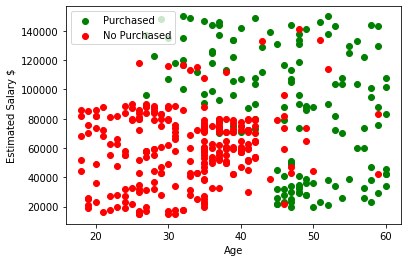

In [8]:
#Decided to exclude Gender in the first trial of modeling since it has almost no linear correlation to Purchase
plt.scatter(df.Age[df.Purchased == 1], df.EstimatedSalary[df.Purchased == 1], color='g', label="Purchased" )
plt.scatter(df.Age[df.Purchased == 0], df.EstimatedSalary[df.Purchased == 0], color='r', label="No Purchased")
plt.xlabel('Age')
plt.ylabel("Estimated Salary $")
plt.legend()
plt.show()

Features and labels

In [9]:
#Features and labels
X = df[['Age',"EstimatedSalary"]]
#Normalyzing X with standar scaler
X= StandardScaler().fit_transform(X)
y = df.Purchased

## Initial Model Test

In [10]:
#Splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)

#Creating and fitting model (polifit of 1 degree, --> linear) -- Optimized after C value
clf = SVC(kernel="poly", degree=1, C=0.1, probability=True)
#clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

#Getting Score
score = clf.score(X_test, y_test)
print(score)

0.875


Determining optimal value of C (error)

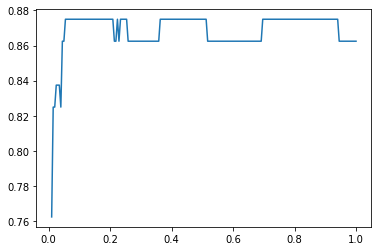

In [11]:
scores=[]
length=1
for i in np.linspace(0.01,length,200):
    clf = SVC(kernel="poly", degree=1, C=i, probability=True)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
    
plt.plot(np.linspace(0.01,length,200), scores)
plt.show()

## Cross Validation

In [15]:
#Scoring dictionary
scoring = {"accuracy": metrics.make_scorer(metrics.accuracy_score),
          "f1_score" : metrics.make_scorer(metrics.f1_score)}

#Kfolds
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

cros_validation_scores = cross_validate(estimator=clf, X=X , y=y , cv=kfold, scoring=scoring)

print(f"Cross Validation Accuracy: {np.mean(cros_validation_scores['test_accuracy']):0.3f} +/- {np.std(cros_validation_scores['test_accuracy']):0.3f} (1 std)")
print(f"Cross Validation f1_score: {np.mean(cros_validation_scores['test_f1_score']):0.3f} +/- {np.std(cros_validation_scores['test_f1_score']):0.3f} (1 std)")



Cross Validation Accuracy: 0.840 +/- 0.036 (1 std)
Cross Validation f1_score: 0.746 +/- 0.066 (1 std)


## Confusion Matrix

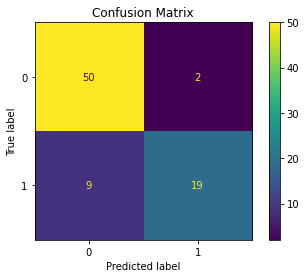

In [12]:
plot_confusion_matrix(clf, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

Ploting Confusion Matrix Probabilities

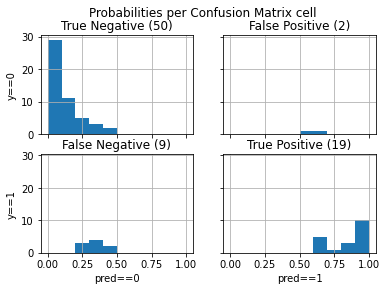

In [13]:
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)

df_predictions = pd.DataFrame({'y': y_test, 'y_proba': y_pred_proba[:,1]})
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
# show true-pos 

bins = np.arange(0, 1.01, 0.1)

def show_quarter(df, query, col, title, ax, bins, x_label=None, y_label=None):
    results = df.query(query)
    results[col].hist(ax=ax, bins=bins); 
    if y_label:
        ax.set_ylabel(y_label)
    if x_label:
        ax.set_xlabel(x_label)
    ax.set_title(title + " ({})".format(results.shape[0])) #IANBOB
    
show_quarter(df_predictions, "y==0 and y_proba < 0.5", "y_proba", "True Negative", axs[0][0], bins, y_label="y==0")
show_quarter(df_predictions, "y==0 and y_proba >= 0.5", "y_proba", "False Positive", axs[0][1], bins)
show_quarter(df_predictions, "y==1 and y_proba >= 0.5", "y_proba", "True Positive", axs[1][1], bins, x_label="pred==1")
show_quarter(df_predictions, "y==1 and y_proba < 0.5", "y_proba", "False Negative", axs[1][0], bins, x_label="pred==0", y_label="y==1")
fig.suptitle("Probabilities per Confusion Matrix cell");

## Visualyzing 
Train Results

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


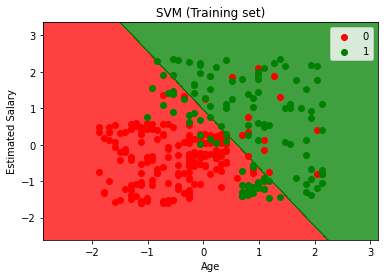

In [16]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, clf.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

Visualyzing Test Results

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


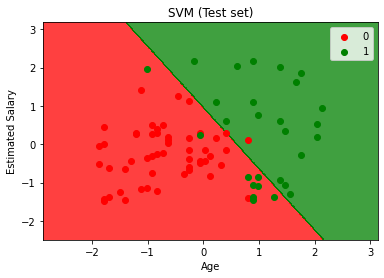

In [17]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, clf.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

Ploting Support vectors

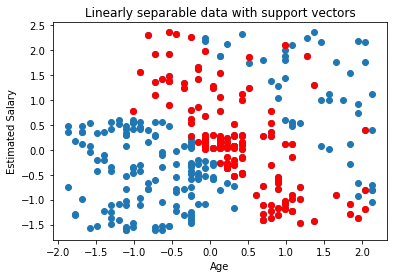

In [18]:
# Get support vectors themselves
support_vectors = clf.support_vectors_

# Visualize support vectors
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.show()